In [1]:
import pandas as pd
import numpy as np
import re
import os
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import tqdm

In [142]:
# import random
# random.seed(42)

In [2]:
df = pd.read_csv('../data/humor/train.csv')
val_hate = pd.read_csv('../data/humor/val.csv')

In [3]:


def clean_text(x):
    x = re.sub(r'http\S+|www\S+|https\S+', '', str(x))
    x = re.sub(r'\s+', ' ', x)
    x = re.sub(r'[^a-zA-Z0-9\s]', '', x)
    x = re.sub(r'\d+', '', x)
    x = re.sub(r'[^\w\s]', '', x)
    x = re.sub(r'#', '', x)
    x = re.sub(r'\s+', ' ', x)
    x = x.strip()
    x = x.lower()
    return x

df['Sentence'] = df['Sentence'].apply(clean_text)

In [4]:

# Create Vocabulary
vocab = Counter(word for sentence in df['Sentence'] for word in sentence.split())
word2idx = {word: i for i, (word, _) in enumerate(vocab.items())}
idx2word = {i: word for word, i in word2idx.items()}
vocab_size = len(word2idx)
print("Vocabulary size:", vocab_size)

Vocabulary size: 7179


In [5]:


class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super(Word2Vec, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embed_dim)
        self.output_embeddings = nn.Embedding(vocab_size, embed_dim)
    
    def forward(self, target, context):
        target_emb = self.embeddings(target)  # (batch_size, embed_dim)
        context_emb = self.output_embeddings(context)  # (batch_size, embed_dim)
        scores = torch.sum(target_emb * context_emb, dim=1)  # Dot product similarity
        return scores

In [6]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [7]:

# Initialize Model

In [9]:

model = Word2Vec(vocab_size, 100).to(device)

In [12]:
# import numpy as np

# # Extract word embeddings
# word_embeddings = model.embeddings.weight.data.cpu().numpy()  # Move to CPU if on GPU

# # Save embeddings with word mappings
# embedding_dict = {idx2word[i]: word_embeddings[i] for i in range(vocab_size)}

# # Save as a NumPy file
# np.save("models/word2vec/humor/word_embeddings.npy", embedding_dict)

# print("✅ Word embeddings saved successfully!")


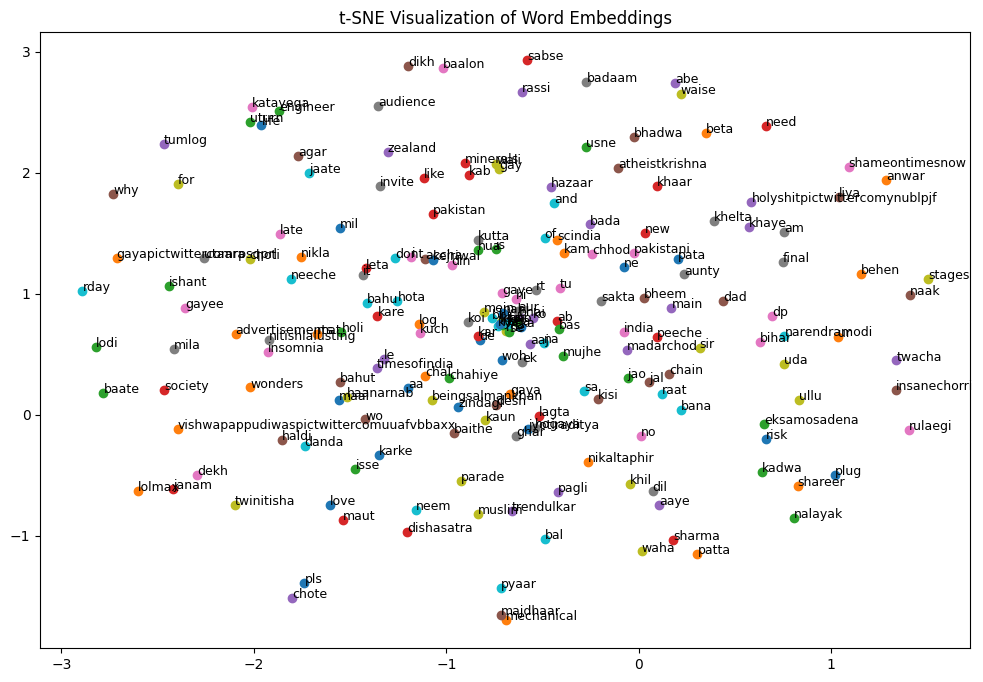

In [13]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Load saved embeddings
embedding_dict = np.load("models/word2vec/humor/word_embeddings_100epochs_cleantext.npy", allow_pickle=True).item()





# Convert to tensor
vocab_size = len(embedding_dict)
embedding_dim = len(next(iter(embedding_dict.values())))  # Get embedding size

# Create embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
word2idx = {word: idx for idx, word in enumerate(embedding_dict.keys())}

for word, idx in word2idx.items():
    embedding_matrix[idx] = embedding_dict[word]

embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)
















# Select 200 most frequent words for visualization
top_words = list(embedding_dict.keys())[:200]
top_embeddings = np.array([embedding_dict[word] for word in top_words])


# Reduce dimensions to 2D
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(top_embeddings)

# Plot embeddings
plt.figure(figsize=(12, 8))
for i, word in enumerate(top_words):
    plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1])
    plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=9)

plt.title("t-SNE Visualization of Word Embeddings")
plt.show()


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def find_similar_words(target_word, top_n=5):
    if target_word not in embedding_dict:
        print("Word not in vocabulary!")
        return

    target_embedding = embedding_dict[target_word].reshape(1, -1)
    all_words = list(embedding_dict.keys())
    all_embeddings = np.array([embedding_dict[word] for word in all_words])

    # Compute cosine similarity
    similarities = cosine_similarity(target_embedding, all_embeddings)[0]
    top_indices = similarities.argsort()[-top_n-1:-1][::-1]

    # Display similar words
    print(f"Words similar to '{target_word}':")
    for idx in top_indices:
        print(f"{all_words[idx]} (Similarity: {similarities[idx]:.4f})")

# Example usage
find_similar_words("mechanical")


Words similar to 'mechanical':
padhao (Similarity: 0.4219)
pyaar (Similarity: 0.4097)
tharaar (Similarity: 0.3657)
panchayats (Similarity: 0.3555)
saifu (Similarity: 0.3476)


In [20]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader

# Load dataset
df = pd.read_csv("../data/humor/train.csv")
df['Sentence'] = df['Sentence'].apply(clean_text)

# Convert text to sequences of word indices
def text_to_sequence(text):
    return [word2idx[word] for word in text.split() if word in word2idx]

df["sequence"] = df["Sentence"].apply(text_to_sequence)

# Padding sequences to the same length
MAX_LEN = 100  # Choose max sentence length
def pad_sequence(seq, max_len=MAX_LEN):
    return seq[:max_len] + [0] * (max_len - len(seq))  # Pad with zeros if shorter

df["padded_seq"] = df["sequence"].apply(lambda x: pad_sequence(x))

# Convert labels to numerical valuesZ
label_mapping = {"humor": 0, "non-humor": 1,}  # Adjust if needed
df["label"] = df["Tag"].astype(int)

In [21]:
df


,Sentence,Tag,sequence,padded_seq,label
0,jyotiraditya scindia is like rassi jal gayee a...,1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 0, 0, 0...",1
1,ishant sharma ko bahut late utaara,1,"[12, 13, 14, 15, 16, 17]","[12, 13, 14, 15, 16, 17, 0, 0, 0, 0, 0, 0, 0, ...",1
2,twinitisha neeche plug nikla hua hai,0,"[18, 19, 20, 21, 22, 23]","[18, 19, 20, 21, 22, 23, 0, 0, 0, 0, 0, 0, 0, ...",0
3,aaj agar india final me hota to kam se kam new...,0,"[24, 25, 26, 27, 28, 29, 30, 31, 32, 31, 33, 3...","[24, 25, 26, 27, 28, 29, 30, 31, 32, 31, 33, 3...",0
4,stages of life of mechanical engineer janam ab...,1,"[38, 39, 40, 39, 41, 42, 43, 44, 45, 46, 47, 4...","[38, 39, 40, 39, 41, 42, 43, 44, 45, 46, 47, 4...",1
...,...,...,...,...,...
2355,nitish lalu scared of modi so much that agar e...,1,"[2036, 856, 3338, 39, 1249, 235, 5469, 745, 25...","[2036, 856, 3338, 39, 1249, 235, 5469, 745, 25...",1
2356,shirishkunder sabzi bana ke rakhna nahi to far...,1,"[2269, 1628, 189, 109, 3243, 10, 30, 2270, 297...","[2269, 1628, 189, 109, 3243, 10, 30, 2270, 297...",1
2357,barkha se bacha lu tujhe seene se laga lu aa c...,0,"[1272, 32, 2384, 4227, 737, 2609, 32, 927, 422...","[1272, 32, 2384, 4227, 737, 2609, 32, 927, 422...",0
2358,bol raha hai mere saath debate karega muh khul...,0,"[295, 62, 23, 459, 2379, 4152, 2568, 595, 4949...","[295, 62, 23, 459, 2379, 4152, 2568, 595, 4949...",0


In [22]:
class HateSpeechDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = torch.tensor(sequences, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

# Create dataset
dataset = HateSpeechDataset(df["padded_seq"].tolist(), df["label"].tolist())

# DataLoader
BATCH_SIZE = 64
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)


In [23]:
# import torch.nn as nn
# import torch.nn.functional as F

# class FFNNClassifier(nn.Module):
#     def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes):
#         super(FFNNClassifier, self).__init__()
#         self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
#         self.fc1 = nn.Linear(embedding_dim, hidden_dim)
#         self.fc2 = nn.Linear(hidden_dim, num_classes)

#     def forward(self, x):
#         x = self.embedding(x)  # (batch_size, max_len, embed_dim)
#         x = torch.mean(x, dim=1)  # Average word embeddings (batch_size, embed_dim)
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x  # No softmax, as we'll use CrossEntropyLoss

import torch.nn as nn
import torch.nn.functional as F

class FFNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, dropout=0.3):
        super(FFNNClassifier, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)

        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.dropout1 = nn.Dropout(dropout)

        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.norm2 = nn.LayerNorm(hidden_dim // 2)
        self.dropout2 = nn.Dropout(dropout)

        self.out = nn.Linear(hidden_dim // 2, num_classes)

    def forward(self, x):
        x = self.embedding(x)  # (batch_size, max_len, embed_dim)
        x = torch.mean(x, dim=1)  # (batch_size, embed_dim)

        x = F.relu(self.norm1(self.fc1(x)))
        x = self.dropout1(x)

        x = F.relu(self.norm2(self.fc2(x)))
        x = self.dropout2(x)

        x = self.out(x)
        return x


In [24]:
# !export CUDA_LAUNCH_BLOCKING=1
import torch.optim as optim
embedding_dim = 100  # Same as the embedding dimension used in Word2Vec
# Set device
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

# Initialize model
model = FFNNClassifier(vocab_size, embedding_dim, hidden_dim=64, num_classes=2).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
from tqdm import tqdm

EPOCHS = 100
for epoch in range(EPOCHS):
    total_loss = 0
    model.train()
    
    loop = tqdm(dataloader, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for sequences, labels in loop:
        sequences, labels = sequences.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()
        
        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())  # Show loss in tqdm

    print(f"Epoch {epoch+1}/{EPOCHS}, Avg Loss: {total_loss / len(dataloader):.4f}")


Epoch 1/100: 100%|██████████| 37/37 [00:00<00:00, 232.84it/s, loss=0.666]


Epoch 1/100, Avg Loss: 0.6935


Epoch 2/100: 100%|██████████| 37/37 [00:00<00:00, 249.41it/s, loss=0.708]


Epoch 2/100, Avg Loss: 0.6772


Epoch 3/100: 100%|██████████| 37/37 [00:00<00:00, 248.25it/s, loss=0.714]


Epoch 3/100, Avg Loss: 0.6782


Epoch 4/100: 100%|██████████| 37/37 [00:00<00:00, 248.13it/s, loss=0.663]


Epoch 4/100, Avg Loss: 0.6790


Epoch 5/100: 100%|██████████| 37/37 [00:00<00:00, 248.47it/s, loss=0.628]


Epoch 5/100, Avg Loss: 0.6771


Epoch 6/100: 100%|██████████| 37/37 [00:00<00:00, 248.31it/s, loss=0.652]


Epoch 6/100, Avg Loss: 0.6773


Epoch 7/100: 100%|██████████| 37/37 [00:00<00:00, 242.70it/s, loss=0.693]


Epoch 7/100, Avg Loss: 0.6755


Epoch 8/100: 100%|██████████| 37/37 [00:00<00:00, 245.97it/s, loss=0.659]


Epoch 8/100, Avg Loss: 0.6733


Epoch 9/100: 100%|██████████| 37/37 [00:00<00:00, 253.93it/s, loss=0.678]


Epoch 9/100, Avg Loss: 0.6733


Epoch 10/100: 100%|██████████| 37/37 [00:00<00:00, 243.44it/s, loss=0.71] 


Epoch 10/100, Avg Loss: 0.6643


Epoch 11/100: 100%|██████████| 37/37 [00:00<00:00, 247.34it/s, loss=0.559]


Epoch 11/100, Avg Loss: 0.6342


Epoch 12/100: 100%|██████████| 37/37 [00:00<00:00, 251.08it/s, loss=0.695]


Epoch 12/100, Avg Loss: 0.6149


Epoch 13/100: 100%|██████████| 37/37 [00:00<00:00, 249.56it/s, loss=0.598]


Epoch 13/100, Avg Loss: 0.5975


Epoch 14/100: 100%|██████████| 37/37 [00:00<00:00, 254.44it/s, loss=0.562]


Epoch 14/100, Avg Loss: 0.5705


Epoch 15/100: 100%|██████████| 37/37 [00:00<00:00, 254.54it/s, loss=0.526]


Epoch 15/100, Avg Loss: 0.5610


Epoch 16/100: 100%|██████████| 37/37 [00:00<00:00, 253.72it/s, loss=0.559]


Epoch 16/100, Avg Loss: 0.5531


Epoch 17/100: 100%|██████████| 37/37 [00:00<00:00, 252.32it/s, loss=0.461]


Epoch 17/100, Avg Loss: 0.5308


Epoch 18/100: 100%|██████████| 37/37 [00:00<00:00, 249.48it/s, loss=0.414]


Epoch 18/100, Avg Loss: 0.5087


Epoch 19/100: 100%|██████████| 37/37 [00:00<00:00, 251.86it/s, loss=0.446]


Epoch 19/100, Avg Loss: 0.4704


Epoch 20/100: 100%|██████████| 37/37 [00:00<00:00, 250.92it/s, loss=0.379]


Epoch 20/100, Avg Loss: 0.4655


Epoch 21/100: 100%|██████████| 37/37 [00:00<00:00, 253.17it/s, loss=0.376]


Epoch 21/100, Avg Loss: 0.4274


Epoch 22/100: 100%|██████████| 37/37 [00:00<00:00, 250.79it/s, loss=0.549]


Epoch 22/100, Avg Loss: 0.4860


Epoch 23/100: 100%|██████████| 37/37 [00:00<00:00, 249.70it/s, loss=0.454]


Epoch 23/100, Avg Loss: 0.4192


Epoch 24/100: 100%|██████████| 37/37 [00:00<00:00, 250.40it/s, loss=0.531]


Epoch 24/100, Avg Loss: 0.4004


Epoch 25/100: 100%|██████████| 37/37 [00:00<00:00, 251.00it/s, loss=0.538]


Epoch 25/100, Avg Loss: 0.3904


Epoch 26/100: 100%|██████████| 37/37 [00:00<00:00, 254.15it/s, loss=0.316]


Epoch 26/100, Avg Loss: 0.3736


Epoch 27/100: 100%|██████████| 37/37 [00:00<00:00, 254.13it/s, loss=0.339]


Epoch 27/100, Avg Loss: 0.3520


Epoch 28/100: 100%|██████████| 37/37 [00:00<00:00, 253.99it/s, loss=0.203]


Epoch 28/100, Avg Loss: 0.3268


Epoch 29/100: 100%|██████████| 37/37 [00:00<00:00, 255.37it/s, loss=0.374]


Epoch 29/100, Avg Loss: 0.3584


Epoch 30/100: 100%|██████████| 37/37 [00:00<00:00, 255.48it/s, loss=0.27] 


Epoch 30/100, Avg Loss: 0.2829


Epoch 31/100: 100%|██████████| 37/37 [00:00<00:00, 255.18it/s, loss=0.286]


Epoch 31/100, Avg Loss: 0.2536


Epoch 32/100: 100%|██████████| 37/37 [00:00<00:00, 251.57it/s, loss=0.164]


Epoch 32/100, Avg Loss: 0.2460


Epoch 33/100: 100%|██████████| 37/37 [00:00<00:00, 249.74it/s, loss=0.186]


Epoch 33/100, Avg Loss: 0.2753


Epoch 34/100: 100%|██████████| 37/37 [00:00<00:00, 252.73it/s, loss=0.117] 


Epoch 34/100, Avg Loss: 0.2453


Epoch 35/100: 100%|██████████| 37/37 [00:00<00:00, 251.32it/s, loss=0.162]


Epoch 35/100, Avg Loss: 0.2139


Epoch 36/100: 100%|██████████| 37/37 [00:00<00:00, 254.74it/s, loss=0.108] 


Epoch 36/100, Avg Loss: 0.2259


Epoch 37/100: 100%|██████████| 37/37 [00:00<00:00, 255.31it/s, loss=0.27] 


Epoch 37/100, Avg Loss: 0.2014


Epoch 38/100: 100%|██████████| 37/37 [00:00<00:00, 254.17it/s, loss=0.276] 


Epoch 38/100, Avg Loss: 0.2066


Epoch 39/100: 100%|██████████| 37/37 [00:00<00:00, 254.67it/s, loss=0.135]


Epoch 39/100, Avg Loss: 0.2236


Epoch 40/100: 100%|██████████| 37/37 [00:00<00:00, 255.51it/s, loss=0.14] 


Epoch 40/100, Avg Loss: 0.1712


Epoch 41/100: 100%|██████████| 37/37 [00:00<00:00, 260.93it/s, loss=0.108]


Epoch 41/100, Avg Loss: 0.1818


Epoch 42/100: 100%|██████████| 37/37 [00:00<00:00, 257.84it/s, loss=0.11]  


Epoch 42/100, Avg Loss: 0.1585


Epoch 43/100: 100%|██████████| 37/37 [00:00<00:00, 254.49it/s, loss=0.105] 


Epoch 43/100, Avg Loss: 0.1537


Epoch 44/100: 100%|██████████| 37/37 [00:00<00:00, 258.54it/s, loss=0.225] 


Epoch 44/100, Avg Loss: 0.1303


Epoch 45/100: 100%|██████████| 37/37 [00:00<00:00, 256.06it/s, loss=0.148] 


Epoch 45/100, Avg Loss: 0.1415


Epoch 46/100: 100%|██████████| 37/37 [00:00<00:00, 252.32it/s, loss=0.181] 


Epoch 46/100, Avg Loss: 0.1183


Epoch 47/100: 100%|██████████| 37/37 [00:00<00:00, 255.19it/s, loss=0.0516]


Epoch 47/100, Avg Loss: 0.1335


Epoch 48/100: 100%|██████████| 37/37 [00:00<00:00, 256.96it/s, loss=0.124] 


Epoch 48/100, Avg Loss: 0.1397


Epoch 49/100: 100%|██████████| 37/37 [00:00<00:00, 253.89it/s, loss=0.175] 


Epoch 49/100, Avg Loss: 0.1398


Epoch 50/100: 100%|██████████| 37/37 [00:00<00:00, 257.21it/s, loss=0.298] 


Epoch 50/100, Avg Loss: 0.1163


Epoch 51/100: 100%|██████████| 37/37 [00:00<00:00, 260.29it/s, loss=0.247] 


Epoch 51/100, Avg Loss: 0.1054


Epoch 52/100: 100%|██████████| 37/37 [00:00<00:00, 278.84it/s, loss=0.0978]


Epoch 52/100, Avg Loss: 0.1109


Epoch 53/100: 100%|██████████| 37/37 [00:00<00:00, 314.60it/s, loss=0.0523]


Epoch 53/100, Avg Loss: 0.1085


Epoch 54/100: 100%|██████████| 37/37 [00:00<00:00, 317.28it/s, loss=0.0866]


Epoch 54/100, Avg Loss: 0.1225


Epoch 55/100: 100%|██████████| 37/37 [00:00<00:00, 317.57it/s, loss=0.0395]


Epoch 55/100, Avg Loss: 0.1006


Epoch 56/100: 100%|██████████| 37/37 [00:00<00:00, 314.62it/s, loss=0.184] 


Epoch 56/100, Avg Loss: 0.1109


Epoch 57/100: 100%|██████████| 37/37 [00:00<00:00, 311.22it/s, loss=0.0131]


Epoch 57/100, Avg Loss: 0.0723


Epoch 58/100: 100%|██████████| 37/37 [00:00<00:00, 361.24it/s, loss=0.0539]


Epoch 58/100, Avg Loss: 0.0844


Epoch 59/100: 100%|██████████| 37/37 [00:00<00:00, 364.85it/s, loss=0.0196]


Epoch 59/100, Avg Loss: 0.0726


Epoch 60/100: 100%|██████████| 37/37 [00:00<00:00, 317.78it/s, loss=0.13]  


Epoch 60/100, Avg Loss: 0.0788


Epoch 61/100: 100%|██████████| 37/37 [00:00<00:00, 367.96it/s, loss=0.0425]


Epoch 61/100, Avg Loss: 0.0735


Epoch 62/100: 100%|██████████| 37/37 [00:00<00:00, 366.92it/s, loss=0.201]


Epoch 62/100, Avg Loss: 0.0679


Epoch 63/100: 100%|██████████| 37/37 [00:00<00:00, 345.54it/s, loss=0.128] 


Epoch 63/100, Avg Loss: 0.0799


Epoch 64/100: 100%|██████████| 37/37 [00:00<00:00, 317.90it/s, loss=0.034]


Epoch 64/100, Avg Loss: 0.0777


Epoch 65/100: 100%|██████████| 37/37 [00:00<00:00, 317.60it/s, loss=0.0759]


Epoch 65/100, Avg Loss: 0.1478


Epoch 66/100: 100%|██████████| 37/37 [00:00<00:00, 320.17it/s, loss=0.0356]


Epoch 66/100, Avg Loss: 0.0925


Epoch 67/100: 100%|██████████| 37/37 [00:00<00:00, 286.25it/s, loss=0.0684]


Epoch 67/100, Avg Loss: 0.0671


Epoch 68/100: 100%|██████████| 37/37 [00:00<00:00, 299.98it/s, loss=0.121] 


Epoch 68/100, Avg Loss: 0.0600


Epoch 69/100: 100%|██████████| 37/37 [00:00<00:00, 254.69it/s, loss=0.089] 


Epoch 69/100, Avg Loss: 0.0528


Epoch 70/100: 100%|██████████| 37/37 [00:00<00:00, 238.14it/s, loss=0.0607]


Epoch 70/100, Avg Loss: 0.0700


Epoch 71/100: 100%|██████████| 37/37 [00:00<00:00, 268.06it/s, loss=0.0832]


Epoch 71/100, Avg Loss: 0.0918


Epoch 72/100: 100%|██████████| 37/37 [00:00<00:00, 298.54it/s, loss=0.13]  


Epoch 72/100, Avg Loss: 0.1010


Epoch 73/100: 100%|██████████| 37/37 [00:00<00:00, 287.78it/s, loss=0.0821]


Epoch 73/100, Avg Loss: 0.0650


Epoch 74/100: 100%|██████████| 37/37 [00:00<00:00, 280.28it/s, loss=0.0647] 


Epoch 74/100, Avg Loss: 0.0737


Epoch 75/100: 100%|██████████| 37/37 [00:00<00:00, 290.20it/s, loss=0.0402]


Epoch 75/100, Avg Loss: 0.0683


Epoch 76/100: 100%|██████████| 37/37 [00:00<00:00, 306.67it/s, loss=0.0565]


Epoch 76/100, Avg Loss: 0.0614


Epoch 77/100: 100%|██████████| 37/37 [00:00<00:00, 308.62it/s, loss=0.0738] 


Epoch 77/100, Avg Loss: 0.0435


Epoch 78/100: 100%|██████████| 37/37 [00:00<00:00, 307.82it/s, loss=0.0361]


Epoch 78/100, Avg Loss: 0.0590


Epoch 79/100: 100%|██████████| 37/37 [00:00<00:00, 309.14it/s, loss=0.468]  


Epoch 79/100, Avg Loss: 0.0603


Epoch 80/100: 100%|██████████| 37/37 [00:00<00:00, 286.66it/s, loss=0.0161]


Epoch 80/100, Avg Loss: 0.0798


Epoch 81/100: 100%|██████████| 37/37 [00:00<00:00, 277.08it/s, loss=0.0275]


Epoch 81/100, Avg Loss: 0.0624


Epoch 82/100: 100%|██████████| 37/37 [00:00<00:00, 292.44it/s, loss=0.0144] 


Epoch 82/100, Avg Loss: 0.0428


Epoch 83/100: 100%|██████████| 37/37 [00:00<00:00, 305.84it/s, loss=0.0223] 


Epoch 83/100, Avg Loss: 0.0362


Epoch 84/100: 100%|██████████| 37/37 [00:00<00:00, 352.77it/s, loss=0.153]


Epoch 84/100, Avg Loss: 0.0745


Epoch 85/100: 100%|██████████| 37/37 [00:00<00:00, 367.95it/s, loss=0.00525]


Epoch 85/100, Avg Loss: 0.0531


Epoch 86/100: 100%|██████████| 37/37 [00:00<00:00, 350.32it/s, loss=0.0436]


Epoch 86/100, Avg Loss: 0.1120


Epoch 87/100: 100%|██████████| 37/37 [00:00<00:00, 344.70it/s, loss=0.0133]


Epoch 87/100, Avg Loss: 0.0303


Epoch 88/100: 100%|██████████| 37/37 [00:00<00:00, 347.38it/s, loss=0.232] 


Epoch 88/100, Avg Loss: 0.0555


Epoch 89/100: 100%|██████████| 37/37 [00:00<00:00, 344.97it/s, loss=0.109] 


Epoch 89/100, Avg Loss: 0.0823


Epoch 90/100: 100%|██████████| 37/37 [00:00<00:00, 328.12it/s, loss=0.00536]


Epoch 90/100, Avg Loss: 0.0430


Epoch 91/100: 100%|██████████| 37/37 [00:00<00:00, 342.77it/s, loss=0.0977]


Epoch 91/100, Avg Loss: 0.0491


Epoch 92/100: 100%|██████████| 37/37 [00:00<00:00, 324.53it/s, loss=0.00613]


Epoch 92/100, Avg Loss: 0.0492


Epoch 93/100: 100%|██████████| 37/37 [00:00<00:00, 250.03it/s, loss=0.00666]


Epoch 93/100, Avg Loss: 0.0356


Epoch 94/100: 100%|██████████| 37/37 [00:00<00:00, 252.36it/s, loss=0.00752]


Epoch 94/100, Avg Loss: 0.0567


Epoch 95/100: 100%|██████████| 37/37 [00:00<00:00, 253.02it/s, loss=0.159]  


Epoch 95/100, Avg Loss: 0.0307


Epoch 96/100: 100%|██████████| 37/37 [00:00<00:00, 251.59it/s, loss=0.00506]


Epoch 96/100, Avg Loss: 0.0194


Epoch 97/100: 100%|██████████| 37/37 [00:00<00:00, 252.89it/s, loss=0.0396]


Epoch 97/100, Avg Loss: 0.0399


Epoch 98/100: 100%|██████████| 37/37 [00:00<00:00, 254.00it/s, loss=0.00557]


Epoch 98/100, Avg Loss: 0.0265


Epoch 99/100: 100%|██████████| 37/37 [00:00<00:00, 285.64it/s, loss=0.0526] 


Epoch 99/100, Avg Loss: 0.0428


Epoch 100/100: 100%|██████████| 37/37 [00:00<00:00, 309.92it/s, loss=0.0126] 

Epoch 100/100, Avg Loss: 0.0434


In [25]:
model.eval()

FFNNClassifier(
  (embedding): Embedding(7179, 100)
  (fc1): Linear(in_features=100, out_features=64, bias=True)
  (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (out): Linear(in_features=32, out_features=2, bias=True)
)

In [26]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate(model, dataloader, device, label_names=["humor", "non-humor"]):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for sequences, labels in tqdm(dataloader, desc="Evaluating"):
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)
            predictions = torch.argmax(outputs, dim=1)

            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Accuracy
    acc = accuracy_score(all_labels, all_preds)
    print(f"\n✅ Accuracy: {acc:.4f}")

    # Classification Report
    print("\n📄 Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=label_names))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_names, yticklabels=label_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()


In [27]:
# Clean the text
val_hate['Sentence'] = val_hate['Sentence'].apply(clean_text)

# Convert text to word index sequences
val_hate['sequence'] = val_hate['Sentence'].apply(text_to_sequence)
val_hate['padded_seq'] = val_hate['sequence'].apply(lambda x: pad_sequence(x))

# Convert label (assuming same label structure as train)
val_hate['label'] = val_hate['Tag'].astype(int)


In [28]:
# Create Dataset
val_dataset = HateSpeechDataset(val_hate["padded_seq"].tolist(), val_hate["label"].tolist())

# Create DataLoader
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 826.01it/s]


✅ Accuracy: 0.6576

📄 Classification Report:
              precision    recall  f1-score   support

       humor       0.55      0.77      0.65       119
   non-humor       0.79      0.58      0.67       176

    accuracy                           0.66       295
   macro avg       0.67      0.68      0.66       295
weighted avg       0.70      0.66      0.66       295



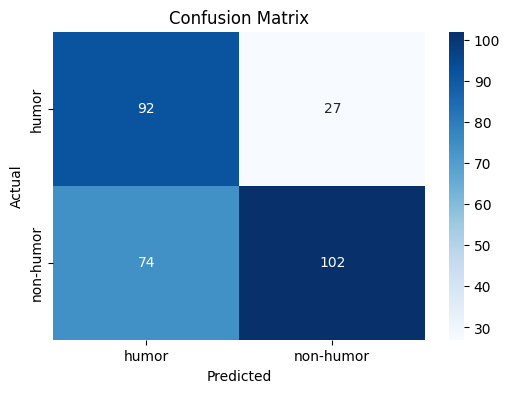

In [29]:
evaluate(model, val_loader, device)


In [30]:
torch.save(model.state_dict(), "models/word2vec/ffnn_classifier_65humorf1_100epoch_cleantext_7kvocab.pth")

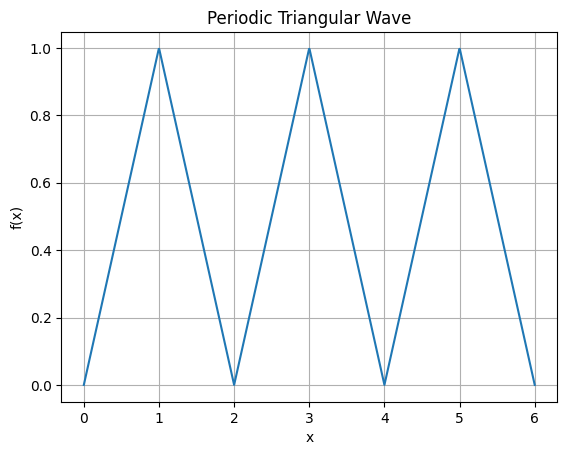

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define the triangular waveform function
def triangular_wave(x):
    return 1 - np.abs((x % 2) - 1)

# Generate values for plotting
x = np.linspace(0, 6, 1000)  # 3 periods for visualization
y = triangular_wave(x)

# Plot the wave
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Periodic Triangular Wave")
plt.grid(True)
plt.show()


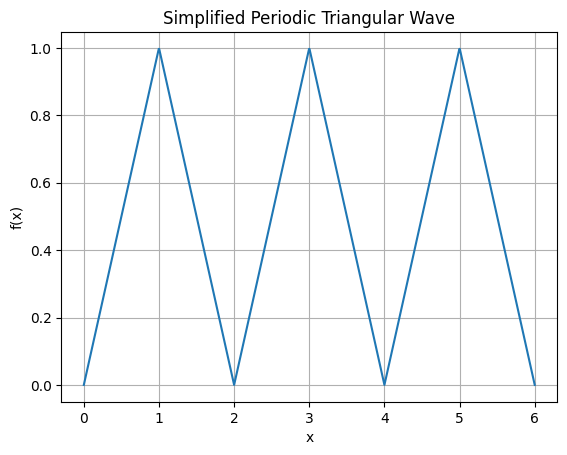

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def triangular_wave(x):
    return (2/np.pi) * abs(np.arcsin(np.sin(np.pi * 0.5*x)))

x = np.linspace(0, 6, 1000)  # 3 periods for visualization
y = triangular_wave(x)

plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Simplified Periodic Triangular Wave")
plt.grid(True)
plt.show()


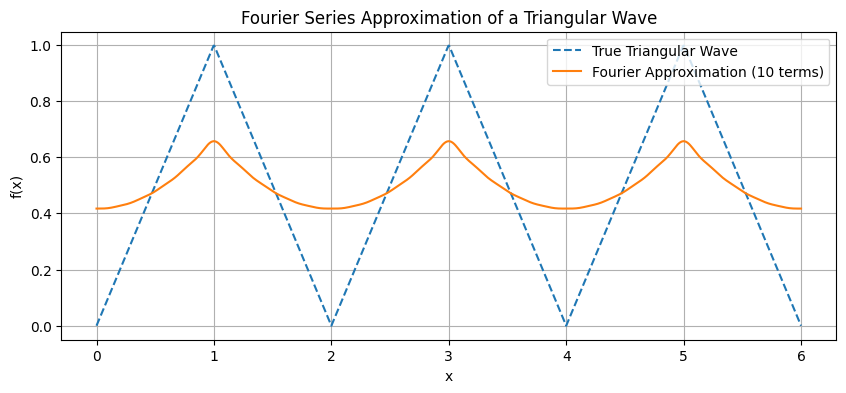

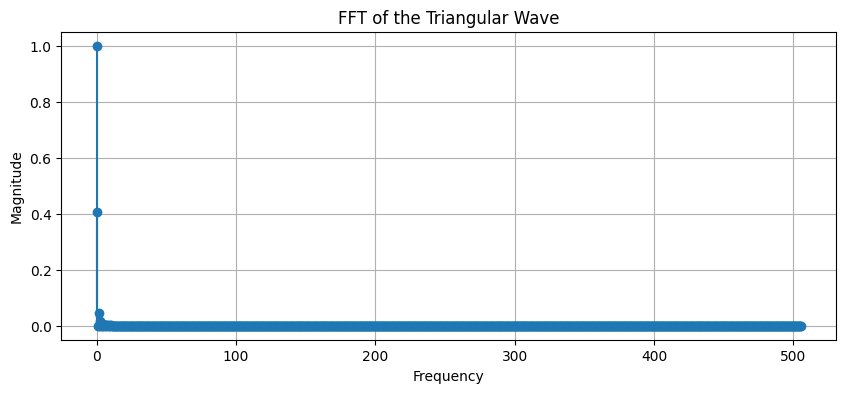

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq

# Define the triangular wave function
def triangular_wave(x):
    return 1 - np.abs((x % 2) - 1)

# Compute Fourier series approximation
def fourier_series(x, terms=10):
    f_approx = np.full_like(x, 0.5)
    for k in range(1, terms + 1):
        coeff = (-1) ** k / (k**2 * np.pi**2)
        f_approx += coeff * np.cos(k * np.pi * x)
    return f_approx

# Generate values for analysis
x = np.linspace(0, 6, 1000)  # Three periods for visualization
y_true = triangular_wave(x)
y_fourier = fourier_series(x, terms=10)

# Compute FFT
N = 2024  # Number of sample points
x_fft = np.linspace(0, 2, N)  # One period
y_fft = triangular_wave(x_fft)

yf = fft(y_fft)
xf = fftfreq(N, d=(2 / N))[:N // 2]  # Frequency components

# Plot the Fourier Series Approximation vs. True Function
plt.figure(figsize=(10, 4))
plt.plot(x, y_true, label="True Triangular Wave", linestyle="dashed")
plt.plot(x, y_fourier, label="Fourier Approximation (10 terms)")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Fourier Series Approximation of a Triangular Wave")
plt.legend()
plt.grid()

# Plot FFT Magnitude Spectrum
plt.figure(figsize=(10, 4))
plt.stem(xf, 2.0 / N * np.abs(yf[:N // 2]), basefmt=" ")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("FFT of the Triangular Wave")
plt.grid()

plt.show()


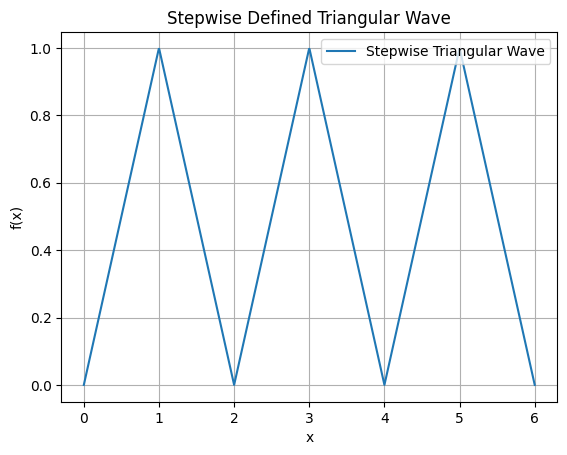

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def stepwise_triangular_wave(x):
    x_mod = x % 2  # Keep within one period
    return np.where(x_mod < 1, x_mod, 2 - x_mod)

# Generate values
x = np.linspace(0, 6, 1000)  # Three periods
y = stepwise_triangular_wave(x)

# Plot
plt.plot(x, y, label="Stepwise Triangular Wave")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Stepwise Defined Triangular Wave")
plt.grid(True)
plt.legend()
plt.show()
